### Data sets were acquired from https://www.kaggle.com/c/titanic

##### Import datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

df_train = pd.read_csv('train.csv', index_col=['PassengerId'])
df_test = pd.read_csv('test.csv', index_col=['PassengerId'])

<AxesSubplot:>

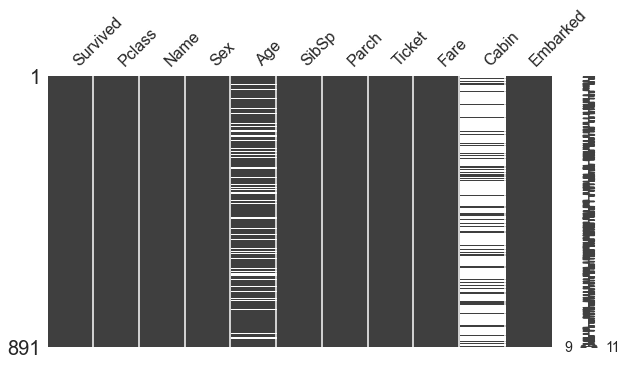

In [2]:
# Check for missing values
import missingno as mi
mi.matrix(df_train, figsize = (10,5))

In [3]:
# Have a look at the first five rows
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis

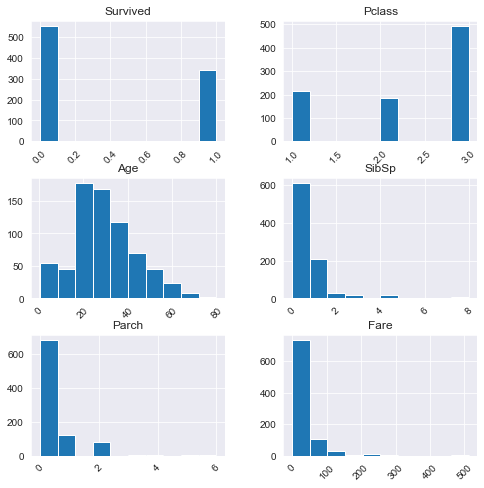

In [4]:
# Plot distributions of numeric features
df_train.hist(figsize=(8,8), xrot=45)
plt.show()

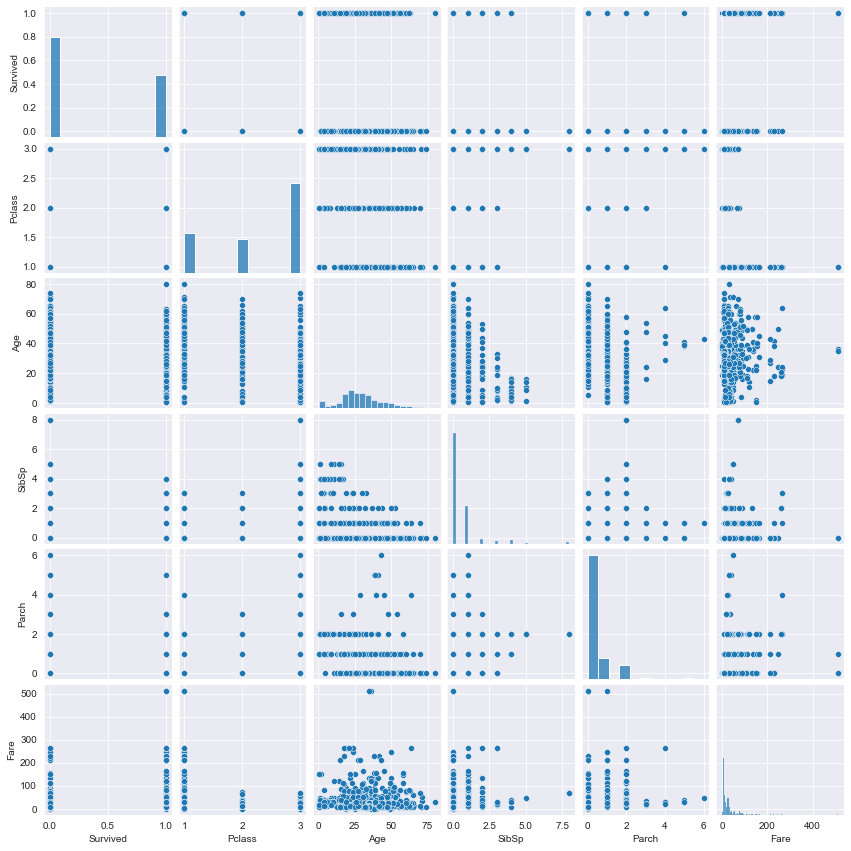

In [5]:
sns.pairplot(df_train, height=2)

In [6]:
# Describe stats of categorical features
df_train.describe(include=['category', 'object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Betros, Mr. Tannous",male,1601,B96 B98,S
freq,1,577,7,4,644


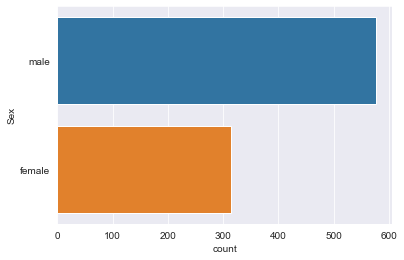

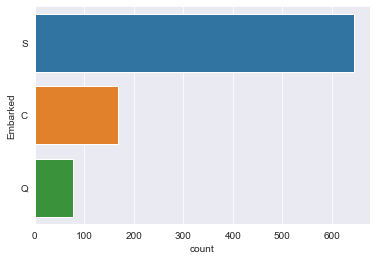

In [7]:
# Display countplot of categorical features
for col in df_test.select_dtypes(exclude='number'):
    if df_test[col].nunique() < 10:
        sns.countplot(y=col, data=df_train)
        plt.show()

### Data cleaning and manipulation

In [8]:
def copy_df(df):
    return df.copy()

def drop_dup(df):
    return df.drop_duplicates()

def drop_missing(df):
    '''Drop columns with missing data over 40%'''
    df.dropna(axis=1, thresh=len(df)*0.6, inplace=True)
    return df

def to_cat(df):
    '''For columns that have few number of unique values (< 0.05), convert to category to save memory'''
    cols = df.columns
    for col in cols:
        ratio = df[col].nunique() / len(df)
        if ratio < 0.05:
            df[col] = df[col].astype('category')
    return df

def drop_irrelevant(df):
    '''Drop irrelevant columns'''
    return df.drop(columns=['Name', 'Ticket', 'Cabin'])

def combine_subgroups(df):
    df.loc[df['SibSp'].isin([3, 4, 5, 8]), 'SibSp'] = 3
    df.loc[df['Parch'].isin([3, 4, 5, 6, 9]), 'Parch'] = 3
    return df

df_train = (df_train.
                pipe(copy_df).
                pipe(drop_dup).
                pipe(drop_irrelevant).
                pipe(drop_missing).
                pipe(to_cat).
                pipe(combine_subgroups)
               )

df_test = (df_test.
                pipe(copy_df).
                pipe(drop_dup).
                pipe(drop_irrelevant).
                pipe(drop_missing).
                pipe(to_cat).
                pipe(combine_subgroups)
               )

In [9]:
# Get X_train and y_train
y = df_train.Survived.copy()
X = df_train.drop(columns='Survived').copy()

In [10]:
# Retrive num_cols and cat_cols
num_cols = list(X._get_numeric_data().columns)
cat_cols = list(set(X.columns) - set(num_cols))

##### Use pipeline to impute and encode features

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

cat_pipe = make_pipeline(
            (SimpleImputer(strategy='most_frequent')),
            (CatBoostEncoder())
            )
num_pipe = make_pipeline(
            (IterativeImputer()),
            (StandardScaler())
            )            
preprocess_pipeline = make_column_transformer(
            (cat_pipe, cat_cols),
            (num_pipe, num_cols)
            )

In [12]:
preprocessor =  preprocess_pipeline.fit(X, y)
X = preprocessor.transform(X)
X_test = preprocessor.transform(df_test)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

##### Build XGB model paired with Optunaz

In [14]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 10,50),
         'num_leaves': trial.suggest_int('num_leaves', 6, 50), 
         'learning_rate': trial.suggest_categorical('learning_rate', [0.1,0.01,0.001]),
         'min_child_samples': trial.suggest_int('min_child_samples', 100, 500), 
         'min_child_weight': trial.suggest_categorical('min_child_weight', [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),
         'subsample': trial.suggest_loguniform('subsample', 0.2, 0.8), 
         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.4, 0.6),
         'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
         'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 1e-1, 1, 5, 10, 20, 50, 100])
        }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(X_val)
    return cross_val_score(model, X, y, 
           n_jobs=-1, cv=StratifiedKFold(10)).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-16 00:17:09,706] A new study created in memory with name: no-name-d9c8a68b-ce4e-46d7-83dd-2bb882f20507
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:12,370] Trial 0 finished with value: 0.7868164794007491 and parameters: {'max_depth': 48, 'num_leaves': 12, 'learning_rate': 0.001, 'min_child_samples': 370, 'min_child_weight': 0.001, 'subsample': 0.4334349936943685, 'colsample_bytree': 0.49347905944924053, 'reg_alpha': 10, 'reg_lambda': 1}. Best is trial 0 with value: 0.7868164794007491.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:12,738] Trial 1 finished with value: 0.7811735330836455 and parameters: {'max_depth': 33, 'num_leaves': 28, 'learning_rate': 0.1, 'min_child_samples': 182, 'min_child_weight': 1e-05, 'subsample': 0.25262430165645, 'colsample_bytree': 0.5120727473496252, 'reg_alpha': 2, 'reg_lambda': 10}. Best is trial 0 with value: 0.7868164794007491.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:17:12,942] Trial 2 finished with value: 0.616167290886392 and parameters: {'max_depth': 15, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 205, 'm

[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:13,228] Trial 3 finished with value: 0.7407615480649188 and parameters: {'max_depth': 24, 'num_leaves': 49, 'learning_rate': 0.01, 'min_child_samples': 190, 'min_child_weight': 1, 'subsample': 0.3185242559098857, 'colsample_bytree': 0.5566762197108182, 'reg_alpha': 10, 'reg_lambda': 100}. Best is trial 0 with value: 0.7868164794007491.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:17:13,437] Trial 4 finished with value: 0.616167290886392 and parameters: {'max_depth': 31, 'num_leaves': 9, 'learning_rate': 0.01, 'min_child_samples': 400, 

[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:17:13,645] Trial 5 finished with value: 0.616167290886392 and parameters: {'max_depth': 28, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 155, 'min_child_weight': 100.0, 'subsample': 0.3005736567685391, 'colsample_bytree': 0.5940972548306435, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.7868164794007491.


[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:14,049] Trial 6 finished with value: 0.7890636704119851 and parameters: {'max_depth': 40, 'num_leaves': 19, 'learning_rate': 0.01, 'min_child_samples': 112, 'min_child_weight': 1e-05, 'subsample': 0.6711981427671567, 'colsample_bytree': 0.4847529737607565, 'reg_alpha': 2, 'reg_lambda': 50}. Best is trial 6 with value: 0.7890636704119851.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:14,258] Trial 7 finished with value: 0.616167290886392 and parameters: {'max_depth': 13, 'num_leaves': 33, 'learning_rate': 0.01, 'min_child_samples': 497, 'min_child_weight': 1000.0, 'subsample': 0.7404441861626453, 'colsample_bytree': 0.5642818806484751, 'reg_alpha': 5, 'reg_lambda': 1}. Best is trial 6 with value: 0.7890636704119851.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:14,561] Trial 8 finished with value: 0.7856304619225968 and parameters: {'max_depth': 30, 'num_leaves': 46, 'learning_rate': 0.1, 'min_child_samples': 214, 'min_child_weight': 1, 'subsample': 0.20685884625736622, 'colsample_bytree': 0.5913896201082687, 'reg_alpha': 5, 'reg_lambda': 5}. Best is trial 6 with value: 0.7890636704119851.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:15,025] Trial 9 finished with value: 0.8058551810237204 and parameters: {'max_depth': 23, 'num_leaves': 38, 'learning_rate': 0.1, 'min_child_samples': 423, 'min_child_weight': 0.1, 'subsample': 0.5286650982909701, 'colsample_bytree': 0.550612764157803, 'reg_alpha': 0, 'reg_lambda': 50}. Best is trial 9 with value: 0.8058551810237204.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:16,124] Trial 10 finished with value: 0.7879525593008739 and parameters: {'max_depth': 19, 'num_leaves': 39, 'learning_rate': 0.001, 'min_child_samples': 486, 'min_child_weight': 0.1, 'subsample': 0.48464994123477817, 'colsample_bytree': 0.40104126716779115, 'reg_alpha': 0, 'reg_lambda': 0}. Best is trial 9 with value: 0.8058551810237204.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:16,544] Trial 11 finished with value: 0.7935330836454432 and parameters: {'max_depth': 41, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 311, 'min_child_weight': 1e-05, 'subsample': 0.7058108556858932, 'colsample_bytree': 0.44801923280667794, 'reg_alpha': 7, 'reg_lambda': 50}. Best is trial 9 with value: 0.8058551810237204.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:16,871] Trial 12 finished with value: 0.7609987515605493 and parameters: {'max_depth': 41, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 295, 'min_child_weight': 10.0, 'subsample': 0.5707579977846827, 'colsample_bytree': 0.42023057571000577, 'reg_alpha': 7, 'reg_lambda': 50}. Best is trial 9 with value: 0.8058551810237204.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:17,461] Trial 13 finished with value: 0.8249188514357053 and parameters: {'max_depth': 48, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 409, 'min_child_weight': 0.01, 'subsample': 0.7972565425927216, 'colsample_bytree': 0.4397360028281899, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:17,959] Trial 14 finished with value: 0.8013732833957553 and parameters: {'max_depth': 21, 'num_leaves': 41, 'learning_rate': 0.1, 'min_child_samples': 437, 'min_child_weight': 0.01, 'subsample': 0.36622291192406264, 'colsample_bytree': 0.4330855994747112, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:18,505] Trial 15 finished with value: 0.8136953807740325 and parameters: {'max_depth': 49, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 439, 'min_child_weight': 0.01, 'subsample': 0.5969411655051592, 'colsample_bytree': 0.5292079033419602, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:19,005] Trial 16 finished with value: 0.8204244694132334 and parameters: {'max_depth': 49, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 335, 'min_child_weight': 0.01, 'subsample': 0.7861843932400356, 'colsample_bytree': 0.5216116206984921, 'reg_alpha': 1, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:19,223] Trial 17 finished with value: 0.616167290886392 and parameters: {'max_depth': 45, 'num_leaves': 28, 'learning_rate': 0.1, 'min_child_samples': 339, 'min_child_weight': 10000.0, 'subsample': 0.7844499598523853, 'colsample_bytree': 0.4575588253842304, 'reg_alpha': 1, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:19,621] Trial 18 finished with value: 0.7654806491885143 and parameters: {'max_depth': 36, 'num_leaves': 32, 'learning_rate': 0.001, 'min_child_samples': 264, 'min_child_weight': 0.01, 'subsample': 0.7965262636659681, 'colsample_bytree': 0.4020061765603519, 'reg_alpha': 1, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:19,904] Trial 19 finished with value: 0.7856928838951311 and parameters: {'max_depth': 50, 'num_leaves': 43, 'learning_rate': 0.1, 'min_child_samples': 368, 'min_child_weight': 0.01, 'subsample': 0.7917462193376685, 'colsample_bytree': 0.5079553817690315, 'reg_alpha': 50, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:20,139] Trial 20 finished with value: 0.616167290886392 and parameters: {'max_depth': 45, 'num_leaves': 24, 'learning_rate': 0.1, 'min_child_samples': 266, 'min_child_weight': 0.01, 'subsample': 0.6555789063664841, 'colsample_bytree': 0.4357452974390341, 'reg_alpha': 100, 'reg_lambda': 0}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:20,705] Trial 21 finished with value: 0.8136828963795255 and parameters: {'max_depth': 49, 'num_leaves': 34, 'learning_rate': 0.1, 'min_child_samples': 459, 'min_child_weight': 0.01, 'subsample': 0.635985094443493, 'colsample_bytree': 0.5284573168984623, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:21,182] Trial 22 finished with value: 0.8092009987515606 and parameters: {'max_depth': 45, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 390, 'min_child_weight': 0.01, 'subsample': 0.5983787575340954, 'colsample_bytree': 0.5243450970245918, 'reg_alpha': 1, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:21,690] Trial 23 finished with value: 0.8024968789013732 and parameters: {'max_depth': 50, 'num_leaves': 29, 'learning_rate': 0.1, 'min_child_samples': 466, 'min_child_weight': 0.01, 'subsample': 0.47955199580594754, 'colsample_bytree': 0.5322727063624048, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:22,272] Trial 24 finished with value: 0.8215480649188514 and parameters: {'max_depth': 37, 'num_leaves': 37, 'learning_rate': 0.1, 'min_child_samples': 336, 'min_child_weight': 0.01, 'subsample': 0.7919580476909633, 'colsample_bytree': 0.4834447932362936, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:23,319] Trial 25 finished with value: 0.8025093632958802 and parameters: {'max_depth': 37, 'num_leaves': 24, 'learning_rate': 0.1, 'min_child_samples': 336, 'min_child_weight': 0.001, 'subsample': 0.7997741433290277, 'colsample_bytree': 0.47215080866183484, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:17:23,542] Trial 26 finished with value: 0.616167290886392 and parameters: {'max_depth': 37, 'num_leaves': 44, 'learning_rate': 0.1, 'min_child_samples

[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:23,888] Trial 27 finished with value: 0.7621098626716605 and parameters: {'max_depth': 43, 'num_leaves': 37, 'learning_rate': 0.001, 'min_child_samples': 270, 'min_child_weight': 10.0, 'subsample': 0.7163509485977535, 'colsample_bytree': 0.4152116473197937, 'reg_alpha': 1, 'reg_lambda': 5}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:24,467] Trial 28 finished with value: 0.8249188514357053 and parameters: {'max_depth': 47, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 303, 'min_child_weight': 0.01, 'subsample': 0.7986624245667397, 'colsample_bytree': 0.4604754240003102, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:17:24,689] Trial 29 finished with value: 0.616167290886392 and parameters: {'max_depth': 46, 'num_leaves': 25, 'learning_rate': 0.001, 'min_child_samples': 

[00:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:25,202] Trial 30 finished with value: 0.8035955056179775 and parameters: {'max_depth': 35, 'num_leaves': 50, 'learning_rate': 0.1, 'min_child_samples': 239, 'min_child_weight': 0.001, 'subsample': 0.4877287682066554, 'colsample_bytree': 0.4650868444256106, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:25,444] Trial 31 finished with value: 0.616167290886392 and parameters: {'max_depth': 47, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 314, 'min_child_weight': 0.01, 'subsample': 0.7831442803226655, 'colsample_bytree': 0.4824308157181438, 'reg_alpha': 100, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:26,017] Trial 32 finished with value: 0.8170536828963796 and parameters: {'max_depth': 42, 'num_leaves': 39, 'learning_rate': 0.1, 'min_child_samples': 352, 'min_child_weight': 0.01, 'subsample': 0.6424934521252369, 'colsample_bytree': 0.5051067775473688, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:26,560] Trial 33 finished with value: 0.8215480649188514 and parameters: {'max_depth': 48, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 290, 'min_child_weight': 0.01, 'subsample': 0.7355674518939386, 'colsample_bytree': 0.43840426124449333, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:27,000] Trial 34 finished with value: 0.8058551810237203 and parameters: {'max_depth': 39, 'num_leaves': 27, 'learning_rate': 0.1, 'min_child_samples': 298, 'min_child_weight': 0.01, 'subsample': 0.6985738169964348, 'colsample_bytree': 0.44383764270068593, 'reg_alpha': 0, 'reg_lambda': 100}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:27,299] Trial 35 finished with value: 0.7789513108614232 and parameters: {'max_depth': 43, 'num_leaves': 36, 'learning_rate': 0.1, 'min_child_samples': 236, 'min_child_weight': 0.01, 'subsample': 0.7366261944679892, 'colsample_bytree': 0.4207158115744686, 'reg_alpha': 10, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:27,733] Trial 36 finished with value: 0.8091885143570536 and parameters: {'max_depth': 47, 'num_leaves': 30, 'learning_rate': 0.1, 'min_child_samples': 404, 'min_child_weight': 1, 'subsample': 0.6174520505392178, 'colsample_bytree': 0.4339613196833556, 'reg_alpha': 2, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:27,976] Trial 37 finished with value: 0.616167290886392 and parameters: {'max_depth': 34, 'num_leaves': 42, 'learning_rate': 0.1, 'min_child_samples': 289, 'min_child_weight': 100.0, 'subsample': 0.369236159117119, 'colsample_bytree': 0.47628278133739516, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:28,468] Trial 38 finished with value: 0.8058426966292135 and parameters: {'max_depth': 27, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 365, 'min_child_weight': 0.01, 'subsample': 0.2778336454285215, 'colsample_bytree': 0.4627037582024903, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:28,851] Trial 39 finished with value: 0.8137078651685392 and parameters: {'max_depth': 39, 'num_leaves': 47, 'learning_rate': 0.1, 'min_child_samples': 383, 'min_child_weight': 1e-05, 'subsample': 0.6807112374076087, 'colsample_bytree': 0.4452344410946462, 'reg_alpha': 5, 'reg_lambda': 1}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:29,073] Trial 40 finished with value: 0.616167290886392 and parameters: {'max_depth': 32, 'num_leaves': 26, 'learning_rate': 0.1, 'min_child_samples': 240, 'min_child_weight': 1000.0, 'subsample': 0.5251560309369157, 'colsample_bytree': 0.4254148026770222, 'reg_alpha': 10, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:29,585] Trial 41 finished with value: 0.8103121098626718 and parameters: {'max_depth': 48, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 310, 'min_child_weight': 0.01, 'subsample': 0.7557517605817927, 'colsample_bytree': 0.5002896512633235, 'reg_alpha': 1, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:30,161] Trial 42 finished with value: 0.8249188514357053 and parameters: {'max_depth': 44, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 326, 'min_child_weight': 0.01, 'subsample': 0.7522627809043713, 'colsample_bytree': 0.48499721045417504, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:30,686] Trial 43 finished with value: 0.8181772784019975 and parameters: {'max_depth': 44, 'num_leaves': 39, 'learning_rate': 0.1, 'min_child_samples': 278, 'min_child_weight': 0.1, 'subsample': 0.6820194926237921, 'colsample_bytree': 0.4867335958517455, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:31,225] Trial 44 finished with value: 0.8237952559300874 and parameters: {'max_depth': 47, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 324, 'min_child_weight': 0.01, 'subsample': 0.7445082339831779, 'colsample_bytree': 0.45707279178060023, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:31,715] Trial 45 finished with value: 0.789076154806492 and parameters: {'max_depth': 47, 'num_leaves': 29, 'learning_rate': 0.01, 'min_child_samples': 177, 'min_child_weight': 0.01, 'subsample': 0.74532969516575, 'colsample_bytree': 0.45985357861489917, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:32,070] Trial 46 finished with value: 0.7968664169787765 and parameters: {'max_depth': 41, 'num_leaves': 22, 'learning_rate': 0.1, 'min_child_samples': 408, 'min_child_weight': 1, 'subsample': 0.6735373659283396, 'colsample_bytree': 0.47479787095346904, 'reg_alpha': 7, 'reg_lambda': 5}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:32,300] Trial 47 finished with value: 0.616167290886392 and parameters: {'max_depth': 50, 'num_leaves': 32, 'learning_rate': 0.1, 'min_child_samples': 323, 'min_child_weight': 100.0, 'subsample': 0.5599868449955001, 'colsample_bytree': 0.40880668246115054, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:32,667] Trial 48 finished with value: 0.7823720349563047 and parameters: {'max_depth': 38, 'num_leaves': 41, 'learning_rate': 0.01, 'min_child_samples': 355, 'min_child_weight': 10.0, 'subsample': 0.7626808949378049, 'colsample_bytree': 0.49698219852960657, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:33,059] Trial 49 finished with value: 0.7699875156054932 and parameters: {'max_depth': 48, 'num_leaves': 34, 'learning_rate': 0.001, 'min_child_samples': 210, 'min_child_weight': 0.01, 'subsample': 0.21161427707615854, 'colsample_bytree': 0.4517989225467506, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:33,564] Trial 50 finished with value: 0.8148189762796505 and parameters: {'max_depth': 43, 'num_leaves': 27, 'learning_rate': 0.1, 'min_child_samples': 283, 'min_child_weight': 1e-05, 'subsample': 0.5898015656305602, 'colsample_bytree': 0.4386082097460689, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:34,197] Trial 51 finished with value: 0.8193008739076154 and parameters: {'max_depth': 10, 'num_leaves': 37, 'learning_rate': 0.1, 'min_child_samples': 318, 'min_child_weight': 0.01, 'subsample': 0.718953373182292, 'colsample_bytree': 0.4682689259101963, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:34,539] Trial 52 finished with value: 0.8058302122347067 and parameters: {'max_depth': 46, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 257, 'min_child_weight': 0.01, 'subsample': 0.7998677365259642, 'colsample_bytree': 0.42856898065883664, 'reg_alpha': 5, 'reg_lambda': 1}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:35,158] Trial 53 finished with value: 0.8193008739076155 and parameters: {'max_depth': 44, 'num_leaves': 36, 'learning_rate': 0.1, 'min_child_samples': 301, 'min_child_weight': 0.01, 'subsample': 0.6340308300082275, 'colsample_bytree': 0.4807718419595157, 'reg_alpha': 0, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:35,727] Trial 54 finished with value: 0.8215480649188514 and parameters: {'max_depth': 50, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 327, 'min_child_weight': 0.01, 'subsample': 0.7596137454480564, 'colsample_bytree': 0.4566704081038563, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:35,967] Trial 55 finished with value: 0.616167290886392 and parameters: {'max_depth': 50, 'num_leaves': 29, 'learning_rate': 0.1, 'min_child_samples': 250, 'min_child_weight': 10000.0, 'subsample': 0.7438607681434555, 'colsample_bytree': 0.45035272896740064, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:36,250] Trial 56 finished with value: 0.7868164794007491 and parameters: {'max_depth': 40, 'num_leaves': 34, 'learning_rate': 0.1, 'min_child_samples': 327, 'min_child_weight': 0.01, 'subsample': 0.7996664629457916, 'colsample_bytree': 0.45474489108459537, 'reg_alpha': 50, 'reg_lambda': 50}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:36,774] Trial 57 finished with value: 0.8204244694132334 and parameters: {'max_depth': 49, 'num_leaves': 32, 'learning_rate': 0.1, 'min_child_samples': 356, 'min_child_weight': 0.01, 'subsample': 0.6961497460491102, 'colsample_bytree': 0.46573295910140605, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:37,292] Trial 58 finished with value: 0.8159425717852683 and parameters: {'max_depth': 46, 'num_leaves': 30, 'learning_rate': 0.1, 'min_child_samples': 419, 'min_child_weight': 0.1, 'subsample': 0.661051250413062, 'colsample_bytree': 0.4448527349636194, 'reg_alpha': 1, 'reg_lambda': 10}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:37,536] Trial 59 finished with value: 0.616167290886392 and parameters: {'max_depth': 42, 'num_leaves': 40, 'learning_rate': 0.1, 'min_child_samples': 384, 'min_child_weight': 0.001, 'subsample': 0.7710577792698985, 'colsample_bytree': 0.4926214751483341, 'reg_alpha': 100, 'reg_lambda': 20}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:37,956] Trial 60 finished with value: 0.7868164794007491 and parameters: {'max_depth': 28, 'num_leaves': 37, 'learning_rate': 0.01, 'min_child_samples': 340, 'min_child_weight': 0.01, 'subsample': 0.6152291924807121, 'colsample_bytree': 0.5140101174751369, 'reg_alpha': 0, 'reg_lambda': 100}. Best is trial 13 with value: 0.8249188514357053.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:38,600] Trial 61 finished with value: 0.8283021223470662 and parameters: {'max_depth': 48, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 297, 'min_child_weight': 0.01, 'subsample': 0.7114714345674509, 'colsample_bytree': 0.44025078803181916, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:39,251] Trial 62 finished with value: 0.8237952559300874 and parameters: {'max_depth': 48, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 303, 'min_child_weight': 0.01, 'subsample': 0.7246874847337104, 'colsample_bytree': 0.43888875632579144, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:39,594] Trial 63 finished with value: 0.8092134831460674 and parameters: {'max_depth': 45, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 309, 'min_child_weight': 0.01, 'subsample': 0.7077748783371688, 'colsample_bytree': 0.44222100652667506, 'reg_alpha': 7, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:40,241] Trial 64 finished with value: 0.823832709113608 and parameters: {'max_depth': 50, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 224, 'min_child_weight': 0.01, 'subsample': 0.6518970799426664, 'colsample_bytree': 0.45950864225247684, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:40,868] Trial 65 finished with value: 0.8238077403245943 and parameters: {'max_depth': 47, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 145, 'min_child_weight': 0.01, 'subsample': 0.6549292511537604, 'colsample_bytree': 0.4484537083932797, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:41,090] Trial 66 finished with value: 0.616167290886392 and parameters: {'max_depth': 49, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 162, 'min_child_weight': 1000.0, 'subsample': 0.5882503559635808, 'colsample_bytree': 0.43061710732276, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:41,607] Trial 67 finished with value: 0.8226841448189763 and parameters: {'max_depth': 46, 'num_leaves': 38, 'learning_rate': 0.1, 'min_child_samples': 100, 'min_child_weight': 0.01, 'subsample': 0.5332440387298778, 'colsample_bytree': 0.41948183014356605, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:42,267] Trial 68 finished with value: 0.8025468164794007 and parameters: {'max_depth': 44, 'num_leaves': 28, 'learning_rate': 0.001, 'min_child_samples': 223, 'min_child_weight': 0.01, 'subsample': 0.6501901737379799, 'colsample_bytree': 0.44031256018472875, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:42,641] Trial 69 finished with value: 0.7991136079900125 and parameters: {'max_depth': 48, 'num_leaves': 30, 'learning_rate': 0.1, 'min_child_samples': 139, 'min_child_weight': 10.0, 'subsample': 0.4507154248801192, 'colsample_bytree': 0.4342944682878643, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:43,316] Trial 70 finished with value: 0.82270911360799 and parameters: {'max_depth': 47, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 131, 'min_child_weight': 0.01, 'subsample': 0.6303384737517643, 'colsample_bytree': 0.47077878283443386, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 61 with value: 0.8283021223470662.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:44,012] Trial 71 finished with value: 0.8316853932584269 and parameters: {'max_depth': 50, 'num_leaves': 35, 'learning_rate': 0.1, 'min_child_samples': 275, 'min_child_weight': 0.01, 'subsample': 0.6985452628236869, 'colsample_bytree': 0.45057578226122896, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:44,657] Trial 72 finished with value: 0.826067415730337 and parameters: {'max_depth': 18, 'num_leaves': 33, 'learning_rate': 0.1, 'min_child_samples': 193, 'min_child_weight': 0.01, 'subsample': 0.6878023885953587, 'colsample_bytree': 0.4484749131168397, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:45,501] Trial 73 finished with value: 0.8294257178526842 and parameters: {'max_depth': 14, 'num_leaves': 36, 'learning_rate': 0.1, 'min_child_samples': 196, 'min_child_weight': 0.01, 'subsample': 0.673001391324645, 'colsample_bytree': 0.44909984219283355, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:45,822] Trial 74 finished with value: 0.7912359550561797 and parameters: {'max_depth': 14, 'num_leaves': 38, 'learning_rate': 0.1, 'min_child_samples': 191, 'min_child_weight': 0.01, 'subsample': 0.6054079826415475, 'colsample_bytree': 0.4621090474026792, 'reg_alpha': 10, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:46,172] Trial 75 finished with value: 0.616167290886392 and parameters: {'max_depth': 17, 'num_leaves': 32, 'learning_rate': 0.1, 'min_child_samples': 198, 'min_child_weight': 10000.0, 'subsample': 0.6949402799871113, 'colsample_bytree': 0.44838722662721797, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:46,493] Trial 76 finished with value: 0.7419101123595505 and parameters: {'max_depth': 16, 'num_leaves': 36, 'learning_rate': 0.1, 'min_child_samples': 222, 'min_child_weight': 0.01, 'subsample': 0.6751601578644829, 'colsample_bytree': 0.4243351815041965, 'reg_alpha': 50, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:47,064] Trial 77 finished with value: 0.8271785268414481 and parameters: {'max_depth': 20, 'num_leaves': 31, 'learning_rate': 0.1, 'min_child_samples': 174, 'min_child_weight': 1, 'subsample': 0.7985792484189707, 'colsample_bytree': 0.45363622046244445, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:47,589] Trial 78 finished with value: 0.8271910112359551 and parameters: {'max_depth': 22, 'num_leaves': 28, 'learning_rate': 0.1, 'min_child_samples': 173, 'min_child_weight': 1, 'subsample': 0.7009756998781596, 'colsample_bytree': 0.4519079272809568, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:48,020] Trial 79 finished with value: 0.8148314606741573 and parameters: {'max_depth': 20, 'num_leaves': 27, 'learning_rate': 0.1, 'min_child_samples': 150, 'min_child_weight': 1, 'subsample': 0.5744467000941758, 'colsample_bytree': 0.41208385082668386, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:48,475] Trial 80 finished with value: 0.8204619225967541 and parameters: {'max_depth': 22, 'num_leaves': 24, 'learning_rate': 0.1, 'min_child_samples': 170, 'min_child_weight': 1, 'subsample': 0.7069569965821644, 'colsample_bytree': 0.4277928654733976, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:48,973] Trial 81 finished with value: 0.8260549313358302 and parameters: {'max_depth': 12, 'num_leaves': 30, 'learning_rate': 0.1, 'min_child_samples': 182, 'min_child_weight': 1, 'subsample': 0.7996232299606258, 'colsample_bytree': 0.4456825879995764, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:49,464] Trial 82 finished with value: 0.8294132334581773 and parameters: {'max_depth': 11, 'num_leaves': 30, 'learning_rate': 0.1, 'min_child_samples': 173, 'min_child_weight': 1, 'subsample': 0.7695547657903195, 'colsample_bytree': 0.45117837029060887, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:50,033] Trial 83 finished with value: 0.8271660424469414 and parameters: {'max_depth': 11, 'num_leaves': 29, 'learning_rate': 0.1, 'min_child_samples': 124, 'min_child_weight': 1, 'subsample': 0.7599414152778069, 'colsample_bytree': 0.45220821410039697, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:50,524] Trial 84 finished with value: 0.8294132334581773 and parameters: {'max_depth': 11, 'num_leaves': 26, 'learning_rate': 0.1, 'min_child_samples': 184, 'min_child_weight': 1, 'subsample': 0.7763099610959485, 'colsample_bytree': 0.4515909666774438, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:51,017] Trial 85 finished with value: 0.8316604244694134 and parameters: {'max_depth': 11, 'num_leaves': 23, 'learning_rate': 0.1, 'min_child_samples': 124, 'min_child_weight': 1, 'subsample': 0.7763858765571421, 'colsample_bytree': 0.45054807604308383, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:51,507] Trial 86 finished with value: 0.8294132334581773 and parameters: {'max_depth': 11, 'num_leaves': 22, 'learning_rate': 0.1, 'min_child_samples': 115, 'min_child_weight': 1, 'subsample': 0.7730678429716697, 'colsample_bytree': 0.45315722897041333, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:51,998] Trial 87 finished with value: 0.8282896379525593 and parameters: {'max_depth': 13, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 111, 'min_child_weight': 1, 'subsample': 0.7779830350969738, 'colsample_bytree': 0.4554696313589579, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:52,398] Trial 88 finished with value: 0.7800873907615481 and parameters: {'max_depth': 13, 'num_leaves': 17, 'learning_rate': 0.001, 'min_child_samples': 113, 'min_child_weight': 1, 'subsample': 0.3185437482695818, 'colsample_bytree': 0.464977192275019, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:52,888] Trial 89 finished with value: 0.8271660424469414 and parameters: {'max_depth': 10, 'num_leaves': 21, 'learning_rate': 0.1, 'min_child_samples': 114, 'min_child_weight': 1, 'subsample': 0.7199271947423416, 'colsample_bytree': 0.4352746357739541, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:53,418] Trial 90 finished with value: 0.8059051186017477 and parameters: {'max_depth': 14, 'num_leaves': 23, 'learning_rate': 0.01, 'min_child_samples': 100, 'min_child_weight': 1, 'subsample': 0.7741485030566922, 'colsample_bytree': 0.4755166563655294, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:53,907] Trial 91 finished with value: 0.8294132334581773 and parameters: {'max_depth': 25, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 156, 'min_child_weight': 1, 'subsample': 0.7768124519346157, 'colsample_bytree': 0.4546874579318263, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:54,478] Trial 92 finished with value: 0.8294132334581773 and parameters: {'max_depth': 25, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 161, 'min_child_weight': 1, 'subsample': 0.7765136716126061, 'colsample_bytree': 0.4566114131787358, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:54,977] Trial 93 finished with value: 0.8282896379525593 and parameters: {'max_depth': 11, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 158, 'min_child_weight': 1, 'subsample': 0.7713561817322053, 'colsample_bytree': 0.44274928933038793, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:55,568] Trial 94 finished with value: 0.8294382022471909 and parameters: {'max_depth': 25, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 158, 'min_child_weight': 1, 'subsample': 0.7323774366616681, 'colsample_bytree': 0.44290104424141735, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:56,059] Trial 95 finished with value: 0.8305493133583021 and parameters: {'max_depth': 25, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 136, 'min_child_weight': 1, 'subsample': 0.7299569774708269, 'colsample_bytree': 0.46800242906543477, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:56,623] Trial 96 finished with value: 0.828314606741573 and parameters: {'max_depth': 25, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 134, 'min_child_weight': 1, 'subsample': 0.7355294774388552, 'colsample_bytree': 0.46854718718722854, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 71 with value: 0.8316853932584269.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:57,233] Trial 97 finished with value: 0.832796504369538 and parameters: {'max_depth': 25, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 153, 'min_child_weight': 1, 'subsample': 0.7395832637174049, 'colsample_bytree': 0.4598895591673816, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:57,796] Trial 98 finished with value: 0.8305493133583021 and parameters: {'max_depth': 24, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 152, 'min_child_weight': 1, 'subsample': 0.669737257993698, 'colsample_bytree': 0.47838862399126764, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:58,381] Trial 99 finished with value: 0.8294382022471909 and parameters: {'max_depth': 26, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 164, 'min_child_weight': 1, 'subsample': 0.668802976162671, 'colsample_bytree': 0.47791112738635305, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:58,866] Trial 100 finished with value: 0.828314606741573 and parameters: {'max_depth': 29, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 123, 'min_child_weight': 1, 'subsample': 0.663423491927523, 'colsample_bytree': 0.480878974133866, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:59,349] Trial 101 finished with value: 0.8294257178526842 and parameters: {'max_depth': 25, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 164, 'min_child_weight': 1, 'subsample': 0.7370951942198978, 'colsample_bytree': 0.4731298210123372, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:17:59,820] Trial 102 finished with value: 0.8271910112359551 and parameters: {'max_depth': 25, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 150, 'min_child_weight': 1, 'subsample': 0.6240699883108098, 'colsample_bytree': 0.46390517902517936, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:00,319] Trial 103 finished with value: 0.8294382022471909 and parameters: {'max_depth': 26, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 160, 'min_child_weight': 1, 'subsample': 0.6776523341096311, 'colsample_bytree': 0.47745101015539165, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:00,830] Trial 104 finished with value: 0.8305493133583021 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 168, 'min_child_weight': 1, 'subsample': 0.6826059219207401, 'colsample_bytree': 0.48861383182541773, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:01,370] Trial 105 finished with value: 0.8294382022471909 and parameters: {'max_depth': 26, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 142, 'min_child_weight': 1, 'subsample': 0.6767739287561202, 'colsample_bytree': 0.4864228175780092, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:01,911] Trial 106 finished with value: 0.819338327091136 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 147, 'min_child_weight': 1, 'subsample': 0.6351280866189444, 'colsample_bytree': 0.48968264667638844, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:02,437] Trial 107 finished with value: 0.8283021223470662 and parameters: {'max_depth': 27, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 139, 'min_child_weight': 1, 'subsample': 0.72864940301962, 'colsample_bytree': 0.4874167875628074, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:02,996] Trial 108 finished with value: 0.8238202247191012 and parameters: {'max_depth': 24, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 165, 'min_child_weight': 1, 'subsample': 0.6870833366945406, 'colsample_bytree': 0.4784373473806644, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:03,520] Trial 109 finished with value: 0.832796504369538 and parameters: {'max_depth': 26, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 203, 'min_child_weight': 1e-05, 'subsample': 0.6711709329200837, 'colsample_bytree': 0.5007345850484779, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:04,080] Trial 110 finished with value: 0.8226966292134831 and parameters: {'max_depth': 29, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 129, 'min_child_weight': 1e-05, 'subsample': 0.643880051109626, 'colsample_bytree': 0.49908205744444134, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 97 with value: 0.832796504369538.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:04,658] Trial 111 finished with value: 0.8339200998751559 and parameters: {'max_depth': 26, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 141, 'min_child_weight': 1e-05, 'subsample': 0.6701849117935103, 'colsample_bytree': 0.5044048664745743, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:05,192] Trial 112 finished with value: 0.8339200998751559 and parameters: {'max_depth': 26, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 147, 'min_child_weight': 1e-05, 'subsample': 0.6702897399058506, 'colsample_bytree': 0.5092603347126777, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:05,880] Trial 113 finished with value: 0.8249313358302123 and parameters: {'max_depth': 23, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 141, 'min_child_weight': 1e-05, 'subsample': 0.599455699824014, 'colsample_bytree': 0.5119610915766777, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:06,496] Trial 114 finished with value: 0.8294132334581772 and parameters: {'max_depth': 31, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 122, 'min_child_weight': 1e-05, 'subsample': 0.6560643956538101, 'colsample_bytree': 0.5053474553832815, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:07,023] Trial 115 finished with value: 0.8294257178526842 and parameters: {'max_depth': 28, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 153, 'min_child_weight': 1e-05, 'subsample': 0.71002602578944, 'colsample_bytree': 0.5235943932311823, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:18:07,263] Trial 116 finished with value: 0.616167290886392 and parameters: {'max_depth': 26, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 13

[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:07,791] Trial 117 finished with value: 0.8282896379525593 and parameters: {'max_depth': 23, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 104, 'min_child_weight': 1e-05, 'subsample': 0.6906191021257168, 'colsample_bytree': 0.5114487466448222, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:08,232] Trial 118 finished with value: 0.78458177278402 and parameters: {'max_depth': 24, 'num_leaves': 14, 'learning_rate': 0.001, 'min_child_samples': 205, 'min_child_weight': 1e-05, 'subsample': 0.6675831416449334, 'colsample_bytree': 0.5027282496829454, 'reg_alpha': 5, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:08,472] Trial 119 finished with value: 0.616167290886392 and parameters: {'max_depth': 26, 'num_leaves': 10, 'learning_rate': 0.01, 'min_child_samples': 140, 'min_child_weight': 100.0, 'subsample': 0.5753083513000395, 'colsample_bytree': 0.5395496492464895, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:09,012] Trial 120 finished with value: 0.832796504369538 and parameters: {'max_depth': 30, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 181, 'min_child_weight': 1e-05, 'subsample': 0.6766132623308376, 'colsample_bytree': 0.49561963980973034, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:09,543] Trial 121 finished with value: 0.8271535580524343 and parameters: {'max_depth': 30, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 186, 'min_child_weight': 1e-05, 'subsample': 0.6322088409450253, 'colsample_bytree': 0.5194255216159549, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:10,077] Trial 122 finished with value: 0.8260549313358302 and parameters: {'max_depth': 29, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 167, 'min_child_weight': 1e-05, 'subsample': 0.7180438037839292, 'colsample_bytree': 0.49159954332561095, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:10,602] Trial 123 finished with value: 0.8305493133583021 and parameters: {'max_depth': 27, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 179, 'min_child_weight': 1e-05, 'subsample': 0.6663923143523898, 'colsample_bytree': 0.49449444901415873, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:11,650] Trial 124 finished with value: 0.8081023720349563 and parameters: {'max_depth': 28, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 179, 'min_child_weight': 1e-05, 'subsample': 0.6819773534535333, 'colsample_bytree': 0.4939987669092211, 'reg_alpha': 0.1, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:12,000] Trial 125 finished with value: 0.7979900124843946 and parameters: {'max_depth': 27, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 147, 'min_child_weight': 1e-05, 'subsample': 0.6154082443965846, 'colsample_bytree': 0.48477857287256276, 'reg_alpha': 7, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:12,523] Trial 126 finished with value: 0.828302122347066 and parameters: {'max_depth': 24, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 207, 'min_child_weight': 1e-05, 'subsample': 0.6544639279781154, 'colsample_bytree': 0.518098800585756, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:13,014] Trial 127 finished with value: 0.8193008739076155 and parameters: {'max_depth': 22, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 153, 'min_child_weight': 0.001, 'subsample': 0.7426350060567336, 'colsample_bytree': 0.5078334826313776, 'reg_alpha': 2, 'reg_lambda': 5}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:13,521] Trial 128 finished with value: 0.826067415730337 and parameters: {'max_depth': 32, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 176, 'min_child_weight': 1e-05, 'subsample': 0.6409816093102075, 'colsample_bytree': 0.5019706931127155, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:14,034] Trial 129 finished with value: 0.8294132334581773 and parameters: {'max_depth': 27, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 189, 'min_child_weight': 0.1, 'subsample': 0.6964264352182743, 'colsample_bytree': 0.4951884256357067, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:14,565] Trial 130 finished with value: 0.8271785268414481 and parameters: {'max_depth': 23, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 128, 'min_child_weight': 1e-05, 'subsample': 0.709932711937891, 'colsample_bytree': 0.48950907309911584, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:14,795] Trial 131 finished with value: 0.616167290886392 and parameters: {'max_depth': 26, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 168, 'min_child_weight': 1000.0, 'subsample': 0.6704973881218745, 'colsample_bytree': 0.48428573207498543, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:15,125] Trial 132 finished with value: 0.7912484394506866 and parameters: {'max_depth': 26, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 143, 'min_child_weight': 1e-05, 'subsample': 0.6736218469545365, 'colsample_bytree': 0.47846576477245184, 'reg_alpha': 10, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:15,447] Trial 133 finished with value: 0.7867665418227217 and parameters: {'max_depth': 24, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 199, 'min_child_weight': 10.0, 'subsample': 0.7267885482146874, 'colsample_bytree': 0.5076104644852567, 'reg_alpha': 2, 'reg_lambda': 50}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:15,928] Trial 134 finished with value: 0.823820224719101 and parameters: {'max_depth': 28, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 159, 'min_child_weight': 1, 'subsample': 0.7003840515312392, 'colsample_bytree': 0.4720689248513993, 'reg_alpha': 2, 'reg_lambda': 1}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:16,439] Trial 135 finished with value: 0.8271660424469414 and parameters: {'max_depth': 29, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 155, 'min_child_weight': 1, 'subsample': 0.752658842695222, 'colsample_bytree': 0.5158759598790975, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:16,690] Trial 136 finished with value: 0.616167290886392 and parameters: {'max_depth': 21, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 135, 'min_child_weight': 10000.0, 'subsample': 0.64047094774311, 'colsample_bytree': 0.49969965942874206, 'reg_alpha': 50, 'reg_lambda': 100}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:17,178] Trial 137 finished with value: 0.8328089887640451 and parameters: {'max_depth': 27, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 180, 'min_child_weight': 1, 'subsample': 0.6811480220755793, 'colsample_bytree': 0.4793135371749217, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:17,691] Trial 138 finished with value: 0.8238077403245943 and parameters: {'max_depth': 31, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 180, 'min_child_weight': 1e-05, 'subsample': 0.6006379977728469, 'colsample_bytree': 0.4697059317634257, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:18,193] Trial 139 finished with value: 0.8294257178526842 and parameters: {'max_depth': 30, 'num_leaves': 18, 'learning_rate': 0.1, 'min_child_samples': 194, 'min_child_weight': 1, 'subsample': 0.6882366083705618, 'colsample_bytree': 0.4671312216849693, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:18,672] Trial 140 finished with value: 0.8226966292134831 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 117, 'min_child_weight': 1, 'subsample': 0.6583097424207804, 'colsample_bytree': 0.4813685906077466, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:19,154] Trial 141 finished with value: 0.8282896379525593 and parameters: {'max_depth': 26, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 146, 'min_child_weight': 1, 'subsample': 0.7189909264889676, 'colsample_bytree': 0.48927409974122116, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:19,638] Trial 142 finished with value: 0.828314606741573 and parameters: {'max_depth': 25, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 172, 'min_child_weight': 1, 'subsample': 0.6941458838484443, 'colsample_bytree': 0.4924841859933535, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:20,130] Trial 143 finished with value: 0.8294257178526842 and parameters: {'max_depth': 24, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 159, 'min_child_weight': 1, 'subsample': 0.7371140554237701, 'colsample_bytree': 0.49735045408777745, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:20,619] Trial 144 finished with value: 0.828314606741573 and parameters: {'max_depth': 27, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 184, 'min_child_weight': 1, 'subsample': 0.6786657202712821, 'colsample_bytree': 0.48552615293679535, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:21,009] Trial 145 finished with value: 0.8103495630461923 and parameters: {'max_depth': 28, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 126, 'min_child_weight': 1e-05, 'subsample': 0.6480071818235793, 'colsample_bytree': 0.4600424301541032, 'reg_alpha': 5, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:21,492] Trial 146 finished with value: 0.819338327091136 and parameters: {'max_depth': 23, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 165, 'min_child_weight': 1, 'subsample': 0.6281964656774706, 'colsample_bytree': 0.5033385417618608, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-16 00:18:21,718] Trial 147 finished with value: 0.616167290886392 and parameters: {'max_depth': 26, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 151, '

[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:22,216] Trial 148 finished with value: 0.8271910112359551 and parameters: {'max_depth': 25, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 138, 'min_child_weight': 1, 'subsample': 0.7085694762783813, 'colsample_bytree': 0.4752644715642421, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 111 with value: 0.8339200998751559.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:22,726] Trial 149 finished with value: 0.8384019975031209 and parameters: {'max_depth': 26, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 171, 'min_child_weight': 0.001, 'subsample': 0.6774029214752249, 'colsample_bytree': 0.47678763283424297, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:23,224] Trial 150 finished with value: 0.8282896379525593 and parameters: {'max_depth': 28, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 179, 'min_child_weight': 0.001, 'subsample': 0.7546366058405284, 'colsample_bytree': 0.5104865719695003, 'reg_alpha': 2, 'reg_lambda': 5}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:23,740] Trial 151 finished with value: 0.8327840199750313 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 171, 'min_child_weight': 1e-05, 'subsample': 0.6633806678400394, 'colsample_bytree': 0.4770113641018206, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:24,275] Trial 152 finished with value: 0.832796504369538 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 170, 'min_child_weight': 0.001, 'subsample': 0.658543439588746, 'colsample_bytree': 0.47471297941752527, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:24,782] Trial 153 finished with value: 0.8294382022471911 and parameters: {'max_depth': 29, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 187, 'min_child_weight': 0.001, 'subsample': 0.6503352968756888, 'colsample_bytree': 0.47442242489397146, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:25,280] Trial 154 finished with value: 0.8249188514357053 and parameters: {'max_depth': 29, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 215, 'min_child_weight': 0.001, 'subsample': 0.619191473443581, 'colsample_bytree': 0.4728962897203871, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:25,844] Trial 155 finished with value: 0.8339200998751559 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 198, 'min_child_weight': 0.001, 'subsample': 0.6494422545139508, 'colsample_bytree': 0.5797127832383319, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:26,233] Trial 156 finished with value: 0.7890761548064918 and parameters: {'max_depth': 27, 'num_leaves': 8, 'learning_rate': 0.01, 'min_child_samples': 213, 'min_child_weight': 0.001, 'subsample': 0.6098375629527509, 'colsample_bytree': 0.565249850787535, 'reg_alpha': 7, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:26,737] Trial 157 finished with value: 0.7924594257178527 and parameters: {'max_depth': 28, 'num_leaves': 9, 'learning_rate': 0.001, 'min_child_samples': 198, 'min_child_weight': 0.001, 'subsample': 0.5867803040182178, 'colsample_bytree': 0.5662931346680858, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:27,231] Trial 158 finished with value: 0.8058551810237203 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 229, 'min_child_weight': 0.001, 'subsample': 0.6959621536755934, 'colsample_bytree': 0.46632903477516335, 'reg_alpha': 0.1, 'reg_lambda': 50}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:27,737] Trial 159 finished with value: 0.8282896379525593 and parameters: {'max_depth': 25, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 174, 'min_child_weight': 0.001, 'subsample': 0.6400244354300082, 'colsample_bytree': 0.4621991929381209, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:28,315] Trial 160 finished with value: 0.828314606741573 and parameters: {'max_depth': 34, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 170, 'min_child_weight': 0.001, 'subsample': 0.657781625862033, 'colsample_bytree': 0.5999420869190408, 'reg_alpha': 2, 'reg_lambda': 1}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:28,885] Trial 161 finished with value: 0.830561797752809 and parameters: {'max_depth': 28, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 191, 'min_child_weight': 0.001, 'subsample': 0.6508323288156825, 'colsample_bytree': 0.5889980027852524, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:29,397] Trial 162 finished with value: 0.8339200998751561 and parameters: {'max_depth': 27, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 199, 'min_child_weight': 0.001, 'subsample': 0.6883196431468532, 'colsample_bytree': 0.551316893245068, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:29,905] Trial 163 finished with value: 0.818214731585518 and parameters: {'max_depth': 31, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 205, 'min_child_weight': 0.001, 'subsample': 0.3791233350076503, 'colsample_bytree': 0.581066551138382, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:30,505] Trial 164 finished with value: 0.8316853932584269 and parameters: {'max_depth': 28, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 188, 'min_child_weight': 0.001, 'subsample': 0.6652881236550604, 'colsample_bytree': 0.5914259825976718, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:31,069] Trial 165 finished with value: 0.8339200998751559 and parameters: {'max_depth': 30, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 201, 'min_child_weight': 0.001, 'subsample': 0.6343566409705299, 'colsample_bytree': 0.5908916235766852, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:31,409] Trial 166 finished with value: 0.7968539325842696 and parameters: {'max_depth': 30, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 217, 'min_child_weight': 0.001, 'subsample': 0.6322219383589218, 'colsample_bytree': 0.5932521176190265, 'reg_alpha': 10, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:31,996] Trial 167 finished with value: 0.8283021223470662 and parameters: {'max_depth': 28, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 198, 'min_child_weight': 0.001, 'subsample': 0.6859563963460015, 'colsample_bytree': 0.5856193315889788, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:32,591] Trial 168 finished with value: 0.828314606741573 and parameters: {'max_depth': 29, 'num_leaves': 44, 'learning_rate': 0.1, 'min_child_samples': 206, 'min_child_weight': 0.001, 'subsample': 0.6264906410153631, 'colsample_bytree': 0.5767301841066234, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:33,034] Trial 169 finished with value: 0.8058302122347065 and parameters: {'max_depth': 28, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 189, 'min_child_weight': 0.001, 'subsample': 0.5576510247132869, 'colsample_bytree': 0.5864519382729734, 'reg_alpha': 2, 'reg_lambda': 100}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:33,604] Trial 170 finished with value: 0.8294382022471909 and parameters: {'max_depth': 30, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 235, 'min_child_weight': 0.001, 'subsample': 0.6520804522597418, 'colsample_bytree': 0.595352958646141, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:34,119] Trial 171 finished with value: 0.8316853932584269 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 190, 'min_child_weight': 0.001, 'subsample': 0.7083151018090376, 'colsample_bytree': 0.5479870420609024, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:34,642] Trial 172 finished with value: 0.828314606741573 and parameters: {'max_depth': 32, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 201, 'min_child_weight': 0.001, 'subsample': 0.7105849589340678, 'colsample_bytree': 0.5565983337606278, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-16 00:18:35,149] Trial 173 finished with value: 0.8305368289637952 and parameters: {'max_depth': 28, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 189, 'min_child_weight': 0.001, 'subsample': 0.6670303507440309, 'colsample_bytree': 0.5422269430450609, 'reg_alpha': 2, 'reg_lambda': 0}. Best is trial 149 with value: 0.8384019975031209.


In [ ]:
# Build model with the best params
best = XGBClassifier(**study.best_params )
best.fit(X, y)

In [ ]:
y_pred = best.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = pd.DataFrame(y_pred, columns=['Survived'], index=df_test.index)
# saving the dataframe 
y_pred.to_csv('Predictions.csv') 

In [ ]:
study.trials_dataframe().head()